# Debugging and performances

In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s" % (pyxpcm.__file__))

xarray: 0.12.1, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py
pyxpcm: /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


## Load data

In [14]:
from pyxpcm import datasets
ds = datasets.argo('sample').load()
# ds = datasets.isas('sample_snapshot').load()
# ds = datasets.isas('sample_series').load()
print('This dataset holds: %.1f MB' % (ds.nbytes / 1e6))
print(ds)

This dataset holds: 34.3 MB
<xarray.Dataset>
Dimensions:    (DEPTH: 282, N_PROF: 7560)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX    (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              If

## Define/fit/predict a standard pyXpcm

In [15]:
from pyxpcm.pcmodel import pcm

In [16]:
# Define vertical axis and features to use:
z = np.arange(0.,-1000.,-10.)
features_pcm = {'temperature': z}
features_in_ds = {'temperature': 'TEMP'}

# features_pcm = {'temperature': z, 'salinity': z}
# features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

In [6]:
# pyXpcm variables added to the dataset can be removed with:
# print('Before:', ds.data_vars)
# ds = ds.pyxpcm.clean()
# print('After cleaning:', ds.data_vars)

## Debugging

Use option ``debug`` to print log messages 

In [22]:
# Clean up dataset of previous results:
ds = ds.pyxpcm.clean()

# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=1)

# Fit with log:
ds.pyxpcm.fit_predict(m, features=features_in_ds, inplace=True);

> Start preprocessing for action 'fit_predict'
	> Preprocessing xarray dataset 'TEMP' as PCM feature 'temperature'
	Input working arrays X (<class 'xarray.core.dataarray.DataArray'>) and z with shapes: (7560, 282) (282,)
	Output axis is in the input axis, not need to interpolate, simple intersection
	Preprocessed array X (<class 'numpy.ndarray'>) with shapes: (7560, 15)
	No need for homogenisation of temperature
> Preprocessing finished, working with final X (<class 'xarray.core.dataarray.DataArray'>) array of shape: (7560, 15)  and sampling dimensions: ['N_PROF']


## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings at execution time

In [23]:
# Create a PCM and use several methods to time:
m = pcm(K=8, features=features_pcm, timeit=True)
m.fit(ds, features=features_in_ds);
m.predict(ds, features=features_in_ds);
m.fit_predict(ds, features=features_in_ds);

  fit.1-preprocess.1-mask: 33 ms
  fit.1-preprocess.2-feature_temperature.1-ravel: 52 ms
  fit.1-preprocess.2-feature_temperature.2-interp: 14 ms
  fit.1-preprocess.2-feature_temperature.3-scale_fit: 7 ms
  fit.1-preprocess.2-feature_temperature.4-scale_transform: 3 ms
  fit.1-preprocess.2-feature_temperature.5-reduce_fit: 14 ms
  fit.1-preprocess.2-feature_temperature.6-reduce_transform: 2 ms
  fit.1-preprocess.2-feature_temperature.total: 97 ms
  fit.1-preprocess: 97 ms
  fit.1-preprocess.3-homogeniser: 0 ms
  fit.1-preprocess.4-xarray: 1 ms
  fit.1-preprocess: 133 ms
  fit.2-fit: 3735 ms
  fit.3-score: 13 ms
  fit: 3883 ms
  predict.1-preprocess.1-mask: 24 ms
  predict.1-preprocess.2-feature_temperature.1-ravel: 30 ms
  predict.1-preprocess.2-feature_temperature.2-interp: 8 ms
  predict.1-preprocess.2-feature_temperature.3-scale_fit: 0 ms
  predict.1-preprocess.2-feature_temperature.4-scale_transform: 3 ms
  predict.1-preprocess.2-feature_temperature.5-reduce_fit: 0 ms
  predict.1-p

In [24]:
# Timing are accessible through a dataframe in the timeit property:
m.timeit

Method       Sub-method    Sub-sub-method         Sub-sub-sub-method
fit          1-preprocess  1-mask                 total                   33.126116
                           2-feature_temperature  1-ravel                 52.566767
                                                  2-interp                14.985323
                                                  3-scale_fit              7.876873
                                                  4-scale_transform        3.235102
                                                  5-reduce_fit            14.788866
                                                  6-reduce_transform       2.789021
                                                  total                   97.665071
                           total                                         231.621027
                           3-homogeniser          total                    0.760078
                           4-xarray               total                    1.441002
       

### Compare details of steps for each method

Sub-method,1-preprocess,2-fit,2-predict,3-score,3-xarray,4-predict,5-xarray,score
Method,,,,,,,,
fit,460.855246,3735.523939,NaN,13.675928,NaN,NaN,NaN,NaN
fit_predict,215.004444,3173.643112,NaN,17.359257,NaN,6.913662,9.932041,9.089708
predict,241.239548,NaN,9.508133,NaN,12.927055,NaN,NaN,11.929035


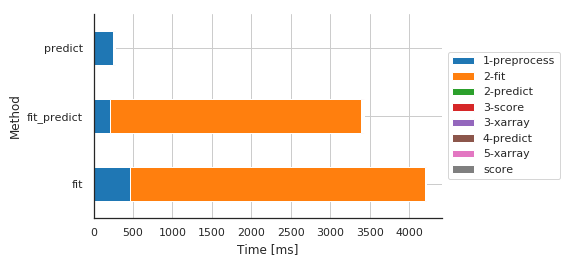

In [26]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method') # Default group/split
df

### Compare preprocessing steps for each method

Sub-sub-method,1-mask,2-feature_temperature,3-homogeniser,4-xarray
Method,,,,
fit,33.126116,193.907022,0.760078,1.441002
fit_predict,22.615910,82.059383,0.771999,1.305103
predict,24.854183,92.962503,0.001192,1.217842


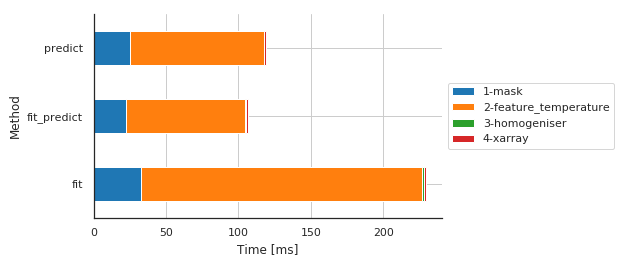

In [27]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Compare details of preprocessing steps for each method

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Method,,,,,,
fit,52.566767,14.985323,7.876873,3.235102,14.788866,2.789021
fit_predict,26.602030,6.126165,0.001192,3.592014,0.003099,4.287004
predict,30.572176,8.127928,0.004053,3.029823,0.003099,3.741264


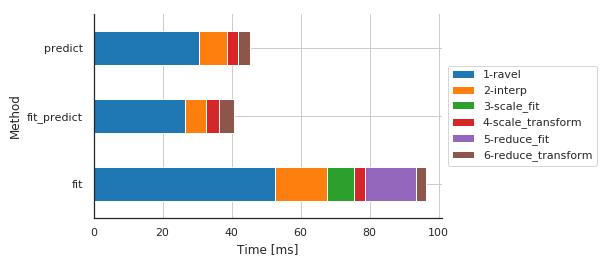

In [28]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Compare details of preprocessing steps for each feature

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Sub-sub-method,,,,,,
2-feature_temperature,109.740973,29.239416,7.882118,9.856939,14.795065,10.817289


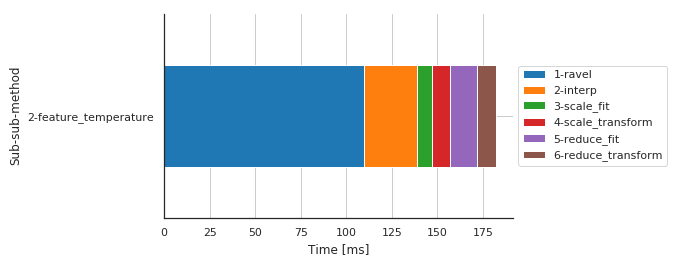

In [29]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method')
df